In [ ]:
import pandas as pd
import pickle
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from dateutil.relativedelta import relativedelta
import itertools
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
relative_path="/content/drive/MyDrive/Credit Risk Analytics/Project2"

# Step 1 - Cleaning the Financial Data

The following cells processed the *Compustat Financials* data and introduced additional fields and ratios beyond those provided in class. We aimed to broaden the range of categories while limiting the number of ratios in each category to reduce high intercorrelations.

In [ ]:
financials=pd.read_pickle(relative_path + "/"+"compustat financials.pickle")

In [ ]:
print(f'There are {len(financials):,} rows in data')
financials.head()

There are 399,016 rows in data


,gvkey,datadate,fyear,fyr,at,lt,ceq,act,lct,invt,...,prcc_f,freq,pstk,dp,capx,intan,gdwl,txt,dv,urect
0,001004,1991-05-31,1990,5,379.958,186.180,193.778,268.399,79.227,156.133,...,14.124999,Annual,0.0,8.256,8.884,7.115,7.115,6.550,7.651,NaN
1,001009,1990-10-31,1990,10,32.335,26.073,6.262,10.047,8.382,2.355,...,5.999998,Annual,0.0,1.971,5.493,0.000,0.000,0.769,0.808,NaN
2,001010,1990-12-31,1990,12,1728.888,1516.287,210.399,523.502,421.777,36.860,...,NaN,Annual,0.0,56.747,140.385,NaN,0.000,-28.220,0.000,NaN
3,001011,1990-12-31,1990,12,7.784,7.117,0.667,1.247,1.246,0.663,...,1.188000,Annual,0.0,0.700,1.273,1.009,NaN,0.000,0.000,NaN
4,001013,1990-10-31,1990,10,181.665,47.652,134.013,102.525,37.335,33.845,...,16.375000,Annual,0.0,11.980,13.734,NaN,NaN,15.269,0.000,NaN


In [ ]:
financials['total_assets'] = financials['at']
del financials['at']
financials = financials[~pd.isnull(financials.total_assets)]
financials = financials.sort_values(by=['gvkey', 'datadate']).copy()
financials = financials.reset_index(drop=True)

### Description of Ratios

### **Profitability Metrics**
* **roa** = Net Income / Total Assets  
  - Measures net income relative to total assets  
  -  A higher ROA indicates that a company efficiently generates profit from its assets, which is favorable for creditworthiness

* **roe** = Net Income / Common Equity  
  - Assesses profitability by comparing net income to common equity  
  - Higher ROE suggests a healthier financial position and more effective use of shareholder funds

* **ebit_margin** = EBIT / Sales  
  - Computes the proportion of sales remaining after covering operating expenses (EBIT)  
  - Strong margins imply efficient operations and lower default risk

* **net_margin** = Net Income / Sales  
  - Measures net income as a fraction of sales  
  - Higher net margins reflect better overall profitability and credit capacity

* **gross_margin** = (Sales – COGS) / Sales  
  - Calculates production efficiency by determining the proportion of revenue remaining after subtracting the cost of goods sold  
  - Higher gross margins suggest better cost control and pricing power, which can support debt servicing

---

### **Leverage / Solvency Metrics**
* **debt_ratio** = Total Liabilities / Total Assets  
  - Measures the proportion of a firm’s assets financed by debt  
  - A higher ratio can indicate greater financial risk, as more debt may strain cash flows

* **de_ratio** = Total Liabilities / Common Equity  
  - Compares total liabilities to common equity  
  - Signals how much debt is used relative to shareholder funds; high leverage may elevate default risk

* **ib_debt_ratio** = (dltt + dlc) / Total Assets  
  - Computes the proportion of interest-bearing debt (long-term debt plus debt in current liabilities) relative to total assets  
  - A higher ratio suggests an increased burden in servicing interest-bearing debt, potentially raising credit risk

* **coverage** = EBIT / Interest Expense (xint)  
  - Calculates the interest coverage ratio by dividing EBIT by interest expense  
  - Indicates a company's ability to cover its interest payments; low coverage raises concerns about default risk

---

### **Efficiency / Operating Metrics**
* **asset_turnover** = Sales / Total Assets  
  - Measures how efficiently a firm uses its assets to generate sales  
  - High turnover suggests efficient asset utilization, supporting stable cash flows

* **inv_turnover** = Sales / Inventories  
  - Calculates how quickly inventory is sold by dividing sales by inventories  
  - Indicates effective inventory management, which helps maintain liquidity

* **rect_turnover** = Sales / Accounts Receivable  
  - Measures how efficiently a firm collects its receivables  
  - Higher turnover reflects efficient collection processes, positively impacting cash flow

* **ap_turnover** = COGS / Accounts Payable  
  - Computes the rate at which a company pays off its suppliers by dividing COGS by accounts payable  
  - A faster turnover can imply prompt payment practices, which may affect liquidity and credit risk

---

### **Liquidity Metrics**
* **current_ratio** = Current Assets / Current Liabilities  
  - Compares current assets to current liabilities  
  - A higher current ratio indicates a better ability to cover short-term obligations, reducing default risk

* **quick_ratio** = (Current Assets – Inventories) / Current Liabilities  
  - Provides a stricter liquidity measure by excluding inventories from current assets  
  - Offers a conservative view of liquidity and the firm's ability to meet short-term liabilities

* **cash_ratio** = (Cash + Short-Term Investments) / Total Liabilities  
  - Measures immediate liquidity by dividing cash and short-term investments by total liabilities  
  - Higher values mean the firm can more easily meet its obligations in the short term

---

### **Cash Flow Metrics**
* **ocf_ratio** = Operating Cash Flow / Total Assets  
  - Compares operating cash flow to total assets  
  - Demonstrates how effectively a company converts its assets into cash for debt repayment

* **capx_ratio** = Capital Expenditures / Total Assets  
  - Measures capital expenditures relative to total assets  
  - Provides insight into reinvestment levels; excessive capex might strain cash resources

* **rnd_sale_ratio** = R&D Expense / Sales  
  - Computes the proportion of sales spent on research and development  
  - Reflects the company’s emphasis on innovation, which may indicate growth potential and lower risk

* **xsga_sale_ratio** = SG&A Expense / Sales  
  - Measures the fraction of sales consumed by selling, general, and administrative expenses  
  - Lower ratios can indicate better cost management and operating efficiency

---

### **Tax Expense Metric**
* **tax_sale_ratio** = Tax Expense / Sales  
  - Divides tax expense by sales to determine the tax burden relative to revenue  
  - A significant tax burden can impact net profitability and, indirectly, credit risk

---



**NOTE: All the ratios that implement to the factor analysis have been adjusted by being divided by an appropriate denominator.**


In [ ]:
list_factor=[
    'roa',
    'roe',
    'ebit_margin',
    'net_margin',
    'gross_margin',
    'debt_ratio',
    'de_ratio',
    'ib_debt_ratio',
    'coverage',
    'asset_turnover',
    'inv_turnover',
    'rect_turnover',
    'ap_turnover',
    'current_ratio',
    'quick_ratio',
    'cash_ratio',
    'ocf_ratio',
    'capx_ratio',
    'rnd_sale_ratio',
    'xsga_sale_ratio',
    'tax_sale_ratio']

# --- Profitability Metrics ---
if {'ni', 'total_assets'}.issubset(financials.columns):
    financials['roa'] = financials['ni'] / financials['total_assets']
if {'ni', 'ceq'}.issubset(financials.columns):
    financials['roe'] = financials['ni'] / financials['ceq']
if {'ebit', 'sale'}.issubset(financials.columns):
    financials['ebit_margin'] = financials['ebit'] / financials['sale']
if {'ni', 'sale'}.issubset(financials.columns):
    financials['net_margin'] = financials['ni'] / financials['sale']
if {'sale', 'cogs'}.issubset(financials.columns):
    financials['gross_margin'] = (financials['sale'] - financials['cogs']) / financials['sale']

# --- Leverage / Solvency Metrics ---
if {'lt', 'total_assets'}.issubset(financials.columns):
    financials['debt_ratio'] = financials['lt'] / financials['total_assets']
if {'lt', 'ceq'}.issubset(financials.columns):
    financials['de_ratio'] = financials['lt'] / financials['ceq']
if {'dltt', 'dlc', 'total_assets'}.issubset(financials.columns):
    financials['ib_debt_ratio'] = (financials['dltt'] + financials['dlc']) / financials['total_assets']
if {'ebit', 'xint'}.issubset(financials.columns):
    financials['coverage'] = financials['ebit'] / financials['xint']

# --- Efficiency / Operating Metrics ---
if {'sale', 'total_assets'}.issubset(financials.columns):
    financials['asset_turnover'] = financials['sale'] / financials['total_assets']
if {'sale', 'invt'}.issubset(financials.columns):
    financials['inv_turnover'] = financials['sale'] / financials['invt']
if {'sale', 'rect'}.issubset(financials.columns):
    financials['rect_turnover'] = financials['sale'] / financials['rect']
if {'cogs', 'ap'}.issubset(financials.columns):
    financials['ap_turnover'] = financials['cogs'] / financials['ap']

# --- Liquidity Metrics ---
if {'act', 'lct'}.issubset(financials.columns):
    financials['current_ratio'] = financials['act'] / financials['lct']
if {'act', 'invt', 'lct'}.issubset(financials.columns):
    financials['quick_ratio'] = (financials['act'] - financials['invt']) / financials['lct']
if {'che', 'lt'}.issubset(financials.columns):
    financials['cash_ratio'] = financials['che'] / financials['lt']

# --- Cash Flow Metrics ---
if {'oancf', 'total_assets'}.issubset(financials.columns):
    financials['ocf_ratio'] = financials['oancf'] / financials['total_assets']
if {'capx', 'total_assets'}.issubset(financials.columns):
    financials['capx_ratio'] = financials['capx'] / financials['total_assets']
if {'xrd', 'sale'}.issubset(financials.columns):
    financials['rnd_sale_ratio'] = financials['xrd'] / financials['sale']
if {'xsga', 'sale'}.issubset(financials.columns):
    financials['xsga_sale_ratio'] = financials['xsga'] / financials['sale']

# --- Tax Expense Metric ---
if {'txt', 'sale'}.issubset(financials.columns):
    financials['tax_sale_ratio'] = financials['txt'] / financials['sale']

# Remove infinities
for ratio in list_factor:
    financials = financials[(financials[ratio] != np.inf) & (financials[ratio] != -np.inf)]

# Remove NaN values
for ratio in list_factor:
    financials = financials[~financials[ratio].isna()]

The following step applies a simple outlier-handling approach by clipping each factor at the 1st and 99th percentiles. This process is sometimes called “winsorization,” which prevents extreme values from skewing or destabilizing the model. Without this filtering, factors with extremely large or small values could lead to numerical overflow (e.g., in logistic regression) or disproportionately influence the model’s coefficients, resulting in inaccurate or unstable predictions. By dropping any remaining NaNs afterward, the dataset retains only rows with valid, clipped factor values, ensuring more robust modeling and fewer numerical issues.

In [ ]:
# Handle Outliers
for factor in list_factor:
    financials[factor].replace([np.inf, -np.inf], np.nan, inplace=True)

    non_null_series = financials[factor].dropna()
    if len(non_null_series) > 0:
        lower_p = np.percentile(non_null_series, 1)
        upper_p = np.percentile(non_null_series, 99)
        financials.loc[financials[factor] < lower_p, factor] = lower_p
        financials.loc[financials[factor] > upper_p, factor] = upper_p


In [ ]:
print(f'There are {len(financials):,} rows in data')
financials.head()

There are 78,712 rows in data


,gvkey,datadate,fyear,fyr,lt,ceq,act,lct,invt,rect,...,rect_turnover,ap_turnover,current_ratio,quick_ratio,cash_ratio,ocf_ratio,capx_ratio,rnd_sale_ratio,xsga_sale_ratio,tax_sale_ratio
39,001010,1990-12-31,1990,12,1516.287,210.399,523.502,421.777,36.860,50.238,...,6.216589,0.989349,1.241182,1.153790,0.284031,0.016413,0.081200,0.003202,0.088726,-0.090359
40,001010,1991-12-31,1991,12,1409.667,346.595,687.329,353.544,24.697,37.171,...,8.180867,14.488278,1.944112,1.874256,0.439505,0.027655,0.025508,0.002960,0.075402,0.128508
41,001010,1992-12-31,1992,12,1388.925,317.529,640.603,469.213,32.797,40.833,...,7.840423,7.160766,1.365271,1.295373,0.403804,0.036455,0.031090,0.002499,0.078798,0.021846
42,001010,1993-12-31,1993,12,1333.668,332.253,440.279,401.525,38.313,43.576,...,7.995892,10.838714,1.096517,1.001098,0.259965,0.005225,0.035290,0.003444,0.096806,0.128508
43,001010,1994-12-31,1994,12,1413.700,395.000,574.300,382.900,51.600,93.700,...,4.060832,6.569079,1.499869,1.365108,0.278843,0.019944,0.039777,0.002891,0.115112,0.034428


# Step 2 -Adding in the Default Data

The following cell extracted the default records from S&P ratings

In [ ]:
defaults = pd.read_pickle(relative_path + "/"+ "S&P ratings.pickle")
defaults = defaults[defaults.ratingsymbol.isin(['D', 'SD', 'R'])]
a = defaults.groupby('gvkey', as_index = False).ratingdate.min()
defaults = defaults.merge(a, on = ['gvkey', 'ratingdate'])
defaults = defaults[['gvkey', 'ratingdate']]
defaults.columns = ['gvkey', 'default_date']

print(f'There are {len(defaults):,} defaults')
defaults.head()

There are 1,211 defaults


,gvkey,default_date
0,065345,2010-06-28
1,126136,2006-09-15
2,060839,2003-06-13
3,021701,2004-02-24
4,063755,2000-05-02


The following cell merged the financial ratios and the defaults from the S&P rating. Then create a six-month offset from the statement date and make sure each company should have at most one default.

In [ ]:
# create a six-month offset from the statement date
data = pd.merge(financials, defaults, on = 'gvkey', how = 'left')
data.loc[data.default_date.isna(), 'default_date'] = dt.date(2999, 12, 31)
data = data.sort_values(['gvkey', 'datadate'])
data['default_minus_six_months'] = [x - relativedelta(months = 6) for x in data.default_date]
data = data[data.datadate < data.default_minus_six_months]
del data['default_minus_six_months']

data['date_plus_six_months'] = [x + relativedelta(months = 7) for x in data.datadate]
data['date_plus_18_months'] = [x + relativedelta(months = 18) for x in data.datadate]

data['default_flag'] = 0
data.loc[(data.default_date > data.date_plus_six_months) & (data.default_date <= data.date_plus_18_months), 'default_flag'] = 1
data = data.drop_duplicates()

print(f'There are {len(data):,} rows in data')
data.default_flag.sum()


There are 77,671 rows in data


np.int64(197)

In [ ]:
data.head()

,gvkey,datadate,fyear,fyr,lt,ceq,act,lct,invt,rect,...,cash_ratio,ocf_ratio,capx_ratio,rnd_sale_ratio,xsga_sale_ratio,tax_sale_ratio,default_date,date_plus_six_months,date_plus_18_months,default_flag
0,001010,1990-12-31,1990,12,1516.287,210.399,523.502,421.777,36.860,50.238,...,0.284031,0.016413,0.081200,0.003202,0.088726,-0.090359,2999-12-31,1991-07-31,1992-06-30,0
1,001010,1991-12-31,1991,12,1409.667,346.595,687.329,353.544,24.697,37.171,...,0.439505,0.027655,0.025508,0.002960,0.075402,0.128508,2999-12-31,1992-07-31,1993-06-30,0
2,001010,1992-12-31,1992,12,1388.925,317.529,640.603,469.213,32.797,40.833,...,0.403804,0.036455,0.031090,0.002499,0.078798,0.021846,2999-12-31,1993-07-31,1994-06-30,0
3,001010,1993-12-31,1993,12,1333.668,332.253,440.279,401.525,38.313,43.576,...,0.259965,0.005225,0.035290,0.003444,0.096806,0.128508,2999-12-31,1994-07-31,1995-06-30,0
4,001010,1994-12-31,1994,12,1413.700,395.000,574.300,382.900,51.600,93.700,...,0.278843,0.019944,0.039777,0.002891,0.115112,0.034428,2999-12-31,1995-07-31,1996-06-30,0


# Step 3 -Single Factor Analysis

In [ ]:
# --- Correlation Calculation ---
list_factor_full=list_factor
data_factor=data[list_factor_full]
data_factor['default_flag']=data['default_flag']
correlation_with_default = data_factor.corr()

# --- AUC Calculation ---

# Calculate AUC scores for each field
auc_scores = {}
for col in list_factor_full:
  auc_score = metrics.roc_auc_score(data['default_flag'], data[col])
  auc_scores[col] = auc_score

# Convert AUC scores to a sorted DataFrame
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC']).sort_values(by='AUC', ascending=False)

In [ ]:
correlation_with_default

,roa,roe,ebit_margin,net_margin,gross_margin,debt_ratio,de_ratio,ib_debt_ratio,coverage,asset_turnover,...,ap_turnover,current_ratio,quick_ratio,cash_ratio,ocf_ratio,capx_ratio,rnd_sale_ratio,xsga_sale_ratio,tax_sale_ratio,default_flag
roa,1.000000,0.023103,0.564668,0.618592,0.131489,-0.566948,0.081633,-0.416472,0.234327,0.050275,...,0.187460,0.132311,0.087081,-0.002949,0.837579,0.012998,-0.445084,-0.564116,0.202466,0.001151
roe,0.023103,1.000000,0.052570,0.052361,0.015730,0.126443,-0.329407,0.102042,0.084401,0.061082,...,0.018712,-0.035145,-0.039565,-0.046980,0.042068,0.018672,-0.065759,-0.048520,0.065304,0.003582
ebit_margin,0.564668,0.052570,1.000000,0.957760,0.192588,-0.205206,0.053522,-0.152382,0.232640,0.238189,...,0.184746,-0.089958,-0.136603,-0.195063,0.600924,-0.001358,-0.824931,-0.984237,0.154666,0.009589
net_margin,0.618592,0.052361,0.957760,1.000000,0.180578,-0.238022,0.054050,-0.182346,0.210198,0.234659,...,0.181967,-0.063204,-0.109813,-0.167036,0.591582,-0.000254,-0.788783,-0.941916,0.143513,0.006768
gross_margin,0.131489,0.015730,0.192588,0.180578,1.000000,-0.110133,-0.030942,-0.092959,0.105090,-0.239763,...,-0.229180,0.159610,0.208149,0.171291,0.141078,-0.070711,-0.023966,-0.054380,0.183250,-0.020943
debt_ratio,-0.566948,0.126443,-0.205206,-0.238022,-0.110133,1.000000,-0.057171,0.852707,-0.061064,0.195630,...,-0.103249,-0.408371,-0.367432,-0.324404,-0.445958,-0.043849,0.103220,0.199575,-0.124503,0.033762
de_ratio,0.081633,-0.329407,0.053522,0.054050,-0.030942,-0.057171,1.000000,-0.034633,-0.004616,0.014984,...,0.019340,-0.053934,-0.055447,-0.065278,0.074282,-0.006601,-0.050351,-0.059747,-0.005095,-0.007415
ib_debt_ratio,-0.416472,0.102042,-0.152382,-0.182346,-0.092959,0.852707,-0.034633,1.000000,-0.047357,0.065122,...,-0.026254,-0.324936,-0.296927,-0.310763,-0.348973,-0.025901,0.070599,0.143975,-0.118491,0.052452
coverage,0.234327,0.084401,0.232640,0.210198,0.105090,-0.061064,-0.004616,-0.047357,1.000000,0.085098,...,0.079968,0.008299,-0.007982,-0.043059,0.266550,0.027792,-0.213200,-0.223949,0.223160,-0.002199
asset_turnover,0.050275,0.061082,0.238189,0.234659,-0.239763,0.195630,0.014984,0.065122,0.085098,1.000000,...,0.274482,-0.255866,-0.323004,-0.267291,0.119626,0.066314,-0.273954,-0.262396,-0.032607,0.001442


In [ ]:
auc_df

,AUC
ib_debt_ratio,0.840410
debt_ratio,0.837785
rect_turnover,0.598313
ap_turnover,0.568255
inv_turnover,0.539067
capx_ratio,0.515409
de_ratio,0.513226
asset_turnover,0.511425
roe,0.489067
ebit_margin,0.435795


For the correlation cutoff, I chose values greater than 0 since the numbers are very small and include even negative correlations—thus, only positive correlations are considered effective.

For the AUC cutoff, I selected values below 0.4 and above 0.6. Since an AUC around 0.5 represents random guessing, I set 0.6 as the lower bound for values above 0.5 and 0.4 as the upper bound for values below 0.5, because even a lower AUC can be useful if inverted and combined with other factors.

In [ ]:
# Filter variables based on correlation cutoff
significant_corr_vars = correlation_with_default[correlation_with_default['default_flag']>0].index.tolist()

# Filter variables based on AUC cutoff
significant_auc_vars = auc_df[(auc_df['AUC'] < 0.4) | (auc_df['AUC'] > 0.6)].index.tolist()

# Intersection of both criteria (recommended for stronger predictors)
selected_vars = list(set(significant_corr_vars) & set(significant_auc_vars))

# Only use the AUC method since the correlation method shows minimal correlations with defualt_flag
selected_vars=significant_auc_vars

In [ ]:
selected_vars

['ib_debt_ratio',
 'debt_ratio',
 'ocf_ratio',
 'gross_margin',
 'coverage',
 'current_ratio',
 'tax_sale_ratio',
 'quick_ratio',
 'xsga_sale_ratio',
 'rnd_sale_ratio',
 'net_margin',
 'roa',
 'cash_ratio']

# Step 4 - Multi-factor Analysis

The following cell generates all possible four-factor combinations and ignores any combination that has a correlation between any two factors higher than 50%.


In [ ]:
factor_combinations = list(itertools.combinations(selected_vars, 4))

# Filter combinations where correlation between any two factors > 0.50
valid_combinations = []
correlation_threshold = 0.50

for combo in factor_combinations:
    correlation_matrix = data[list(combo)].corr().abs()
    if (correlation_matrix.values[np.triu_indices_from(correlation_matrix, 1)] <= correlation_threshold).all():
        valid_combinations.append(combo)

print(f"Number of valid combinations: {len(valid_combinations)}")


Number of valid combinations: 199


The following cell runs logistic regression for all the valid combinations and return the top three regressions.

In [ ]:
# Target variable
y = data['default_flag']

# Track model performance
results = []

# Fit logistic regression for each combination
for combo in valid_combinations:
    X = data[list(combo)].copy()
    X = sm.add_constant(X)  # Add constant for intercept

    # Handle missing values by filling with median
    X = X.fillna(X.median())

    # Fit logistic regression model
    try:
        model = sm.Logit(y, X).fit()  # disp=0 suppresses convergence warnings
        results.append({
            'factors': combo,
            'pseudo_r_squared': model.prsquared,
            'model': model
        })
    except Exception as e:
        print(f"Model failed for combination {combo}: {e}")

# Rank models by Pseudo-R-squared
top_3_models = sorted(results, key=lambda x: x['pseudo_r_squared'], reverse=True)[:3]

# Display top 3 models
top_3_summary = pd.DataFrame({
    'Factors': [', '.join(model['factors']) for model in top_3_models],
    'Pseudo R-Squared': [model['pseudo_r_squared'] for model in top_3_models]
})

# Print detailed summaries of the top 3 models
print("\nDetailed Results for Top 3 Models:")
for idx, model_info in enumerate(top_3_models, start=1):
    print(f"\nModel {idx}: {', '.join(model_info['factors'])}")
    print(model_info['model'].summary())

Optimization terminated successfully.
         Current function value: 0.016363
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016323
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016245
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016293
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.015921
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.016540
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016465
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016483
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016038
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.

Based on the model summary of the top 3 models:
*   The top 3 regressions have pretty close Pseudo R-squared and none of the models show a significantly stronger fit than others.
*   Model 1 has the highest Pseudo R-squared (0.1187), but the improvement is marginal.
*  The Pseudo R-squared values across all three models are quite low, indicating that the models explain only a small proportion of the variance in the default risk.



In [ ]:
# Calculate Predicted PDs (Probability of Default) for Top 3 Models
pd_columns = []

for model_info in top_3_models:
    model = model_info['model']
    pd_col = f'pd_{", ".join(model_info["factors"])}'
    data[pd_col] = model.predict()
    pd_columns.append(pd_col)

pd_data = data[['default_flag'] + pd_columns].head(10)

print("\nPredicted PDs for Top 3 Models:")
print(pd_data.drop('default_flag', axis=1))

# Calculate AUC for Each Top 3 Model
auc_scores = {}
for model_info in top_3_models:
    pd_column = f'pd_{", ".join(model_info["factors"])}'
    auc_score = metrics.roc_auc_score(data['default_flag'], data[pd_column])
    auc_scores[pd_column] = auc_score

auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC']).sort_values(by='AUC', ascending=False)
print("\nAUC Scores for Top 3 Models:")
print(auc_df)




Predicted PDs for Top 3 Models:
   pd_ib_debt_ratio, tax_sale_ratio, xsga_sale_ratio, cash_ratio  \
0                                           0.012113               
1                                           0.000514               
2                                           0.001946               
3                                           0.000672               
4                                           0.001875               
5                                           0.000166               
6                                           0.000459               
7                                           0.000379               
8                                           0.000431               
9                                           0.000091               

   pd_ib_debt_ratio, coverage, xsga_sale_ratio, cash_ratio  \
0                                           0.003644         
1                                           0.002125         
2                               

### Discussions
#### **Quantitative Difference**
* The Pseudo R-squared values are extremely close. The difference between Model 1, Model 2 and Model 3 is minimal.
* Statistically, the models are not significantly different in terms of explanatory power.

#### **Qualitative Difference**

##### **Model 1 Analysis**
- Significant coefficients for **ib_debt_ratio** (p-value < 0.05)  
- Significant coefficients for **tax_sale_ratio** (p-value < 0.05)  
- Significant coefficients for **xsga_sale_ratio** (p-value < 0.05)  
- Significant coefficients for **cash_ratio** (p-value < 0.05)  

---

##### **Model 2 Analysis**
- Significant coefficients for **ib_debt_ratio** (p-value < 0.05)  
- Significant coefficients for **xsga_sale_ratio** (p-value < 0.05)  
- Significant coefficients for **cash_ratio** (p-value < 0.05)  
- **coverage** is **NOT significant** (p-value = 0.057>0.05)  

---

##### **Model 3 Analysis**
- Significant coefficients for **ib_debt_ratio** (p-value < 0.05)  
- Significant coefficients for **xsga_sale_ratio** (p-value < 0.05)  
- Significant coefficients for **cash_ratio** (p-value < 0.05)  
- **gross_margin** is **NOT significant** (p-value = 0.112>0.05)






---

##### **Discussions**
- All models identify **ib_debt_ratio**, **xsga_sale_ratio** and **cash_ratio** as **significant predictors** of default risk.  
- **coverage**  and **gross_margin** not significant among the three models, reducing its value as a key predictor.

### Conclusion
- Statistically, the models are NOT significantly different in terms of both AUC and Pseudo R-squared.
- Qualitatively, Model 1 shows a slight advantage in both AUC and Pseudo R-squared.
- Recommended Model: **Model 1** — Highest Pseudo R-squared and AUC, all the factors are siginificant

In [ ]:
# Model 1 Summary
best_model_info = top_3_models[0]  # Selecting the top model based on pseudo R-squared
print("\nSummary of the Best Model:")
print(best_model_info['model'].summary())


Summary of the Best Model:
                           Logit Regression Results                           
Dep. Variable:           default_flag   No. Observations:                77671
Model:                          Logit   Df Residuals:                    77666
Method:                           MLE   Df Model:                            4
Date:                Tue, 25 Mar 2025   Pseudo R-squ.:                  0.1187
Time:                        03:19:25   Log-Likelihood:                -1211.1
converged:                       True   LL-Null:                       -1374.2
Covariance Type:            nonrobust   LLR p-value:                 2.314e-69
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.3045      0.142    -37.438      0.000      -5.582      -5.027
ib_debt_ratio       1.5607      0.137     11.417      0.000       1.293       1.829
tax_

### Findings

* Debt Ratio (ib_debt_ratio)
  * A significant positive coefficient (1.5607) suggests that firms with higher debt ratios are more prone to default. This aligns with credit risk theory — as debt levels increase, financial obligations become more challenging to meet.

* Tax-to-Sales Ratio (tax_sale_ratio)

  * The negative coefficient (-12.1260) is both large and highly significant. This may suggest that firms with higher tax payments relative to sales are more compliant and stable, thus less risky.

* SG&A-to-Sales Ratio (xsga_sale_ratio)

    * The negative coefficient (-2.4142) indicates that higher SG&A expenses relative to sales reduce default risk. While counterintuitive at first, this may imply that firms investing in marketing, operations, and administration are actively improving sales stability, reducing default risk.

* Cash Ratio (cash_ratio)

    * The negative coefficient (-3.5264) suggests that firms with higher liquidity (cash reserves) are less likely to default. This is a crucial risk mitigator in financial distress scenarios.

# Step 5 -Post-modeling test

## Average predicted PD for defaulted records and non-defaulted records

In [ ]:
best_model = best_model_info['model']
data['predicted_pd'] = best_model.predict()
avg_pd_defaulted = data[data['default_flag'] == 1]['predicted_pd'].mean()
avg_pd_non_defaulted = data[data['default_flag'] == 0]['predicted_pd'].mean()
print(f"Average PD for Defaulted Records: {avg_pd_defaulted:.4f}")
print(f"Average PD for Non-Defaulted Records: {avg_pd_non_defaulted:.4f}")

Average PD for Defaulted Records: 0.0085
Average PD for Non-Defaulted Records: 0.0025


The defaulted records are four times more numerous than the non-defaulted records, which makes sense. However, the PD is relatively small for both groups. This might be because we have only 197 defaulted records out of a total of approximately 77,671 records.

## Average values of the variables in my chosen model for defaulted and non-defaulted records

In [ ]:
# List of model variables
model_vars = ['ib_debt_ratio', 'xsga_sale_ratio', 'tax_sale_ratio', 'cash_ratio']
# Calculate average values for defaulted and non-defaulted records
avg_values = data.groupby('default_flag')[model_vars].mean()

print(avg_values)

              ib_debt_ratio  xsga_sale_ratio  tax_sale_ratio  cash_ratio
default_flag                                                            
0                  0.297413         0.648126        0.013341    0.563486
1                  0.653833         0.240169        0.001077    0.074955


*   ib_debt_ratio
    *  Defaulted firms have significantly higher debt ratios. This aligns with financial risk theory — higher debt levels increase financial obligations, making it harder for firms to meet payments, thus raising the risk of default. High debt ratios are strongly associated with default risk.
*   xsga_sale_ratio
  *  Non-defaulted firms exhibit higher SG&A expenses relative to sales. This is interesting and may suggest that stable firms are investing more in administrative functions, marketing, or customer support — factors that contribute to sales stability and long-term growth.Conversely, defaulted firms may have cut costs aggressively in these areas, potentially weakening their stability. Low SG&A ratios may indicate cost-cutting behavior common in struggling firms, increasing the risk of default.

* tax_sale_ratio
  * Non-defaulted firms pay significantly higher taxes relative to sales. This suggests that firms in financial distress often reduce or delay tax payments as liquidity issues arise. Higher tax-to-sales ratios may also signal better profitability or compliance — a positive indicator of financial health. A very low tax-to-sales ratio may serve as a red flag for potential default.

* cash_ratio
    * Non-defaulted firms have substantially higher cash reserves relative to liabilities. This makes sense since cash-rich firms are better equipped to handle financial shocks or unexpected expenses.Firms with very low cash ratios are more vulnerable to liquidity crises, increasing the likelihood of default.





## Confusion Matrices

In [ ]:
# Set a threshold to convert predicted probabilities into 0/1 labels
threshold = 0.01

data['pred_label'] = (data['predicted_pd'] >= threshold).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(data['default_flag'], data['pred_label'])
print("Confusion Matrix:\n", cm)

# Typically, if default=0/1, the confusion matrix follows this format:
#  [[TN, FP],
#   [FN, TP]]

# 3) View the classification report (precision, recall, f1-score, etc.)
cr = classification_report(data['default_flag'], data['pred_label'])
print("\nClassification Report:\n", cr)

Confusion Matrix:
 [[75158  2316]
 [  149    48]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     77474
           1       0.02      0.24      0.04       197

    accuracy                           0.97     77671
   macro avg       0.51      0.61      0.51     77671
weighted avg       1.00      0.97      0.98     77671



From the confusion matrix and classification report, we see that while overall accuracy remains relatively high (97%), the model’s ability to identify actual defaults (i.e., recall for class 1) is still limited (24%). The low precision (2%) and moderate recall highlight the challenge of correctly classifying a relatively small group of defaulters without also flagging a larger number of non-defaulters. This underscores the inherent trade-off between catching more defaults and avoiding excessive false alarms. Depending on business objectives, further tuning of the threshold or exploring alternative methods (such as cost-sensitive training or more complex models) might help achieve a better balance between precision and recall for the default class.

## ROC Curve

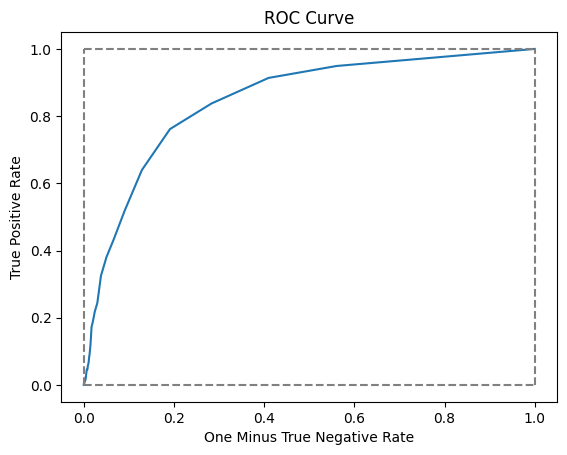

In [ ]:
x = []
y = []

thresholds = np.arange(0.0, 1.001, 0.001)

for threshold in thresholds:
    data['pred_label'] = (data['predicted_pd'] >= threshold).astype(int)

    cm = confusion_matrix(data['default_flag'], data['pred_label'])
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

    x.append(fpr)
    y.append(tpr)


fig, ax = plt.subplots()
ax.plot(x, y, label='ROC-like Curve')
ax.plot([0,0],[0,1], color='gray', linestyle='--')
ax.plot([1,1],[0,1], color='gray', linestyle='--')
ax.plot([0,1],[0,0], color='gray', linestyle='--')
ax.plot([0,1],[1,1], color='gray', linestyle='--')
ax.set_xlabel('One Minus True Negative Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
plt.show()